A simple GAN.

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses, Input
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from scipy.ndimage import gaussian_filter
import time
from IPython import display

# (x_train, _), (x_test, _) = fashion_mnist.load_data()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
#
# x_train = x_train[..., tf.newaxis]
# x_test = x_test[..., tf.newaxis]

(mn_x_train, mn_x_train_labels), (mn_x_test, test_labels) = mnist.load_data()

# Uncomment the below to reduce size of dataset, for testing purposes
# sample_size = 100
#
# mn_x_train = mn_x_train[:sample_size]
# mn_x_train_labels = mn_x_train_labels[:sample_size]

mn_x_train = mn_x_train.astype('float32') / 255.
mn_x_test = mn_x_test.astype('float32') / 255.
mn_x_train_labels = mn_x_train_labels.astype('float32')
mn_x_test_labels = test_labels.astype('float32')

mn_x_train = mn_x_train[..., tf.newaxis]
mn_x_test = mn_x_test[..., tf.newaxis]

# print(x_train.shape)

In [177]:
# # This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

class GAN(tf.keras.Model):
    """Generative Adversarial Network."""

    def __init__(self, gen_input_dim=100, generator_aim="ODD_EVEN"):
        super(GAN, self).__init__()
        self.gen_input_dim = gen_input_dim

        if generator_aim == "ODD_EVEN":
            num_labels = 2
        elif generator_aim == "SPECIFIC":
            num_labels = 10
        else:
            raise ValueError(f"generator_aim: {generator_aim} must be either ODD_EVEN or SPECIFIC")


        self.generator = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(gen_input_dim,)),
                layers.Dense(7 * 7 * 256),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Reshape((7, 7, 256)),
                layers.Conv2DTranspose(128, 5, strides=1, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2DTranspose(64, 5, strides=2, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid')
            ],
            name='generator'
        )

        self.num_labels = num_labels
        self.discriminator = GAN.create_multi_output_discriminator(num_labels)


        @tf.function
        def sample(self, eps=None):
            if eps is None:
                eps = tf.random.normal(shape=(100, self.latent_dim))
            return self.generator(eps, training=False)


    @staticmethod
    def create_multi_output_discriminator(num_labels = 2):
        """
        Creates a discriminator that takes in an image and a label and outputs a vector.

        Takes in input a flattened image, along with a vector concatenated with the label.

        :param num_labels: number of labels to choose from
        :return: model
        """
        image_input = Input(shape=(28,28,1), name='image_input')
        label_input = Input(shape=(num_labels,), name='label_input')

        flattened_image = layers.Flatten()(image_input)

        concatenated_inputs = layers.concatenate([flattened_image, label_input])

        discriminator = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(28*28 + num_labels,)),  # Corrected input shape
                layers.Dense(64, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(2 + num_labels, activation='softmax')
            ]
        )
        output = discriminator(concatenated_inputs)

        return Model(inputs=[image_input, label_input], outputs=output, name='discriminator')


In [185]:
cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

class GAN_trainer():

    def __init__(self, train_images, train_labels, gen_input_dim=100, batch_size=256, beta=0.5, generator_aim="ODD_EVEN"):
        self.gan = GAN(gen_input_dim, generator_aim)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.gen_input_dim = gen_input_dim
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, self.gen_input_dim])
        self.batch_size = batch_size

        self.images_dataset = tf.data.Dataset.from_tensor_slices(train_images)
        self.labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

        self.dataset = tf.data.Dataset.zip((self.images_dataset, self.labels_dataset)).shuffle(train_images.shape[0]).batch(
            self.batch_size) # Combine images and labels into dataset.

        self.num_batches = train_images.shape[0] // self.batch_size
        self.image_labels = None
        self.beta = beta
        self.generator_aim = generator_aim

    def create_generator_input_and_labels(self, batch_size=-1):
        """
        Creates generator input and labels.

        Input is a random vector with size determined by gen_input_dim and another label vector concanated with it. Looks roughly like:

        [random_vector, label_vector]

        :return: generator input and labels created.
        """
        if batch_size == -1:
            batch_size = self.batch_size

        if self.generator_aim == "ODD_EVEN":
            generator_noise = tf.random.normal([batch_size, self.gen_input_dim - 2])
            generator_labels = GAN_trainer.random_one_hot_matrix(batch_size, 2)
            generator_input = tf.concat([generator_noise, generator_labels], axis=1)
            return generator_input, generator_labels
        elif self.generator_aim == "SPECIFIC":
            generator_noise = tf.random.normal([batch_size, self.gen_input_dim- 10])
            generator_labels = GAN_trainer.random_one_hot_matrix(batch_size, 10)
            # print(generator_labels.shape)
            generator_input = tf.concat([generator_noise, generator_labels], axis=1)
            return generator_input, generator_labels
        else:
            raise ValueError(f"Generator aim: '{self.generator_aim}' not recognized") # For my own sanity

    # @tf.function
    def real_images_one_hot_labels(self, labels):
        """
        Creates the labels for the real images.

        Labels depend on what the generator is trying to do. E.g. create odd or even numbers or create specific numbers.

        :param labels: tensor containing labels of the real images. Encoded as integer, e.g. 4, 6, 2
        :return: labels encoded as one-hot tensors
        """
        if self.generator_aim == "ODD_EVEN":
            even_mask = tf.equal(tf.math.mod(labels, 2), 0)
            odd_mask = tf.logical_not(even_mask)
            even_labels = tf.where(even_mask, tf.ones_like(labels), tf.zeros_like(labels))
            odd_labels = tf.where(odd_mask, tf.ones_like(labels), tf.zeros_like(labels))
            real_labels = tf.stack([even_labels, odd_labels], axis=-1)
        elif self.generator_aim == "SPECIFIC":
            labels = tf.cast(labels, dtype=tf.int32)
            real_labels = tf.one_hot(labels, depth=10)
        else:
            raise ValueError(f"Generator aim: '{self.generator_aim}' not recognized")  # For my own sanity

        return real_labels

    def discriminator_output_to_one_hot(self, discriminator_output):
        """
        Translates discriminator output to one_hot_encoding

        Not entirely sure if this function is necessary. You can more or less ignore it for now.
        :param discriminator_output:
        :return:
        """
        first_two = tf.argmax(discriminator_output[:, :2], axis=1)
        first_two = tf.expand_dims(first_two, axis=1)
        last_ones = tf.argmax(discriminator_output[:, 2:], axis=1)
        last_ones = tf.expand_dims(last_ones, axis=1)
        first_two = tf.cast(first_two, dtype=tf.int32)
        last_ones = tf.cast(last_ones, dtype=tf.int32) + 2
        indices = tf.concat([first_two, last_ones], axis=1)

        num_rows = tf.shape(indices)[0]
        row_range = tf.range(num_rows)
        row_indices = tf.tile(tf.expand_dims(row_range, 1), [1, tf.shape(indices)[1]])
        row_indices_flat = tf.reshape(row_indices, [-1])
        col_indices_flat = tf.reshape(indices, [-1])
        expanded_indices = tf.stack([row_indices_flat, col_indices_flat], axis=-1)
        expanded_indices = tf.cast(expanded_indices, dtype=tf.int64)

        output_size = tf.shape(discriminator_output)[0]

        values = [1 for _ in range(2 * output_size)]

        shape = tf.cast(tf.shape(discriminator_output), "int64")
        output = tf.SparseTensor(expanded_indices, values, shape)

        dense = tf.sparse.to_dense(output)

        return dense

    # @tf.function
    def train_step(self, images, this_batch_size=-1):
        """
        Completes a training step

        :param images: images to train on
        :param this_batch_size: batch size of this step. If -1, the default batch size of the trainer is used (256). Since the final batch can have less than 256 els, this is necessary.
        :return: generator loss and discriminator loss
        """
        image_labels = self.real_images_one_hot_labels(self.image_labels)

        generator_input, generator_labels = self.create_generator_input_and_labels(this_batch_size)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.gan.generator(generator_input, training=True)

            disc_real_output = self.gan.discriminator([images, image_labels], training=True)
            disc_gen_output = self.gan.discriminator([generated_images, generator_labels], training=True)

            gen_loss = self.generator_loss(disc_gen_output, generator_labels)
            disc_loss = self.discriminator_loss(disc_real_output, disc_gen_output, image_labels, generator_labels)

            # print("gen_loss: ", gen_loss)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.gan.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.gan.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(
                zip(gradients_of_generator, self.gan.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(
                zip(gradients_of_discriminator, self.gan.discriminator.trainable_variables))

        return gen_loss, disc_loss

    # @tf.function
    def discriminator_loss(self, real_output, generator_output, real_expected_class_labels, generator_expected_class_labels):
        """
        Computes the loss function for the discriminator.

        Uses cross entropy loss.

        I've split up the discriminator loss between the loss associated with distinguishing real images from fake ones, and the loss associated with distinguishing between classes of images. You can use
        beta to tweak the importance of each of these losses. If beta is None, the loss associated with distinguishing between classes is weighted by the number of classes.

        :param real_output: Discriminator's output for real images. Combines whether` it thinks input is authentic or not AND what class it thinks it is.
        :param generator_output: Discriminator's output for generated images. Combines whether it thinks input is authentic or not AND what class it thinks it is.
        :param real_expected_class_labels: expected one-hot encoded classes for real images.
        :param generator_expected_class_labels: expected one-hot encoded classes for generated images
        :return: The computed discriminator loss.
        """

        input_size = tf.shape(real_output)[0]

        # First find loss associated with whether discriminator could tell real from fake

        # Create expected labels rows for real and generated images
        real_expected_authenticity_label_row = tf.constant([0, 1], dtype=tf.float32) # Changed from [0, num_labels]
        gen_expected_authenticity_label_row = tf.constant([1, 0], dtype=tf.float32)

        # Now create the expected labels for the entire batch
        real_expected_authenticity_labels = tf.tile(tf.expand_dims(real_expected_authenticity_label_row, axis=0), [input_size, 1])
        gen_expected_authenticity_labels = tf.tile(tf.expand_dims(gen_expected_authenticity_label_row, axis=0), [input_size, 1])
        real_expected_authenticity_labels = tf.cast(real_expected_authenticity_labels, tf.float32)
        gen_expected_authenticity_labels = tf.cast(gen_expected_authenticity_labels, tf.float32)

        # Extract the part of the output from the descriminator that corresponds to whether it thinks the input is legit or not. These are the first two entries. The rest are the class labels.
        real_output_legit_labels = real_output[:, :2]
        gen_output_legit_labels = generator_output[:, :2]
        real_output_legit_labels = tf.cast(real_output_legit_labels, tf.float32)
        gen_output_legit_labels = tf.cast(gen_output_legit_labels, tf.float32)

        # Now finally find the loss associated with the descriminator being able to tell real images from fake generated
        real_authenticity_loss = cat_cross_entropy(real_expected_authenticity_labels, real_output_legit_labels)
        gen_authenticity_loss = cat_cross_entropy(gen_expected_authenticity_labels, gen_output_legit_labels)

        total_authenticity_loss = real_authenticity_loss + gen_authenticity_loss

        # Now find loss associated with whether discriminator could tell the class of the real image

        # First cast to float32 to avoid errors
        real_expected_class_labels = tf.cast(real_expected_class_labels, tf.float32)
        generator_expected_class_labels = tf.cast(generator_expected_class_labels, tf.float32)

        # Extract the output of the discriminator that corresponds to the class labels
        real_output_class_labels = real_output[:, 2:]
        generator_output_class_labels = generator_output[:, 2:]
        real_output_class_labels = tf.cast(real_output_class_labels, tf.float32)
        gen_output_class_labels = tf.cast(generator_output_class_labels, tf.float32)

        real_class_loss = cat_cross_entropy(real_expected_class_labels, real_output_class_labels)
        gen_class_loss = cat_cross_entropy(generator_expected_class_labels, gen_output_class_labels)

        total_class_loss = real_class_loss + gen_class_loss

        return self.combine_ce_loss(total_authenticity_loss, total_class_loss)

    # @tf.function
    def generator_loss(self, discriminator_output, generator_labels, num_labels=2):
        """
        Computes the loss function for the generator.

        Takes in the output of the descriminator from the generated images and the labels that the generator was trying to create.

        :param discriminator_output: output from the descriminator, I.e. If the discriminator believes the images are legit or not
        :return: the cross entropy loss
        """
        output_size = tf.shape(discriminator_output)[0]

        # Separate loss due to whether the discriminator thinks the generated images are legit or not, and what class descriminator thought images were

        # First calculate loss due to whether descriminator thought images were authentic or not
        expected_authenticity_row = tf.constant([0, 1], dtype=tf.float32)
        expected_authenticity_labels = tf.repeat(tf.expand_dims(expected_authenticity_row, axis=0), repeats=output_size, axis=0)

        output_authenticity_labels = discriminator_output[:, :2]
        authenticity_loss = cat_cross_entropy(expected_authenticity_labels, output_authenticity_labels)

        # Now calculate loss due to whether descriminator thought images were of the correct class
        expected_class_labels = tf.cast(generator_labels, tf.float32)
        output_class_labels = discriminator_output[:, 2:]
        class_loss = cat_cross_entropy(expected_class_labels, output_class_labels)

        return self.combine_ce_loss(authenticity_loss, class_loss)

    def combine_ce_loss(self, authenticity_loss, class_loss):
        """
        Combines the authenticity loss and the class loss into a single loss value. Controlled by the beta parameter.

        :param authenticity_loss: loss due to authenticity. E.g. for discriminator this is the total loss due to it not being able to tell real images from fake ones
        :param class_loss: loss due to class. E.g. for discriminator this is the total loss due to it not being able to tell the class of an image (generated or real)
        :return: total loss as described above
        """
        return authenticity_loss * self.beta + class_loss * (1-self.beta)

    @staticmethod
    def random_one_hot_matrix(num_rows, num_cols):
        """
        Creates a random one hot matrix

        :param num_rows: number of rows in the matrix
        :param num_cols: number of columns in the matrix
        :return: a random one hot matrix
        """
        return tf.one_hot(tf.random.uniform(shape=(num_rows,), minval=0, maxval=num_cols, dtype=tf.int32), num_cols)

    def train(self, epochs):
        self.gen_losses = []
        self.disc_losses = []
        for epoch in range(epochs):
            start = time.time()

            gen_loss = 0
            disc_loss = 0

            print(f"Epoch {epoch + 1}/{epochs}")

            i = 0

            for batch in self.dataset:
                # print(f"Epoch {epoch + 1}/{epochs}, Batch {i}/{self.num_batches}", flush=True)

                image_batch, label_batch = batch
                this_batch_size = tf.shape(image_batch)[0]

                self.image_labels = label_batch
                gl, dl = self.train_step(image_batch, this_batch_size=this_batch_size)
                gen_loss += gl
                disc_loss += dl

                # print(f"gn: {gen_loss}, dl: {disc_loss}")
                i += 1

            print(f"Num batches: {self.num_batches}")
            print(f"Div: {disc_loss / self.num_batches}")

            self.gen_losses.append(gen_loss / self.num_batches)
            self.disc_losses.append(disc_loss / self.num_batches)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

            self.generate_and_save_images(epoch=epoch)

        # Generate after the final epoch
        display.clear_output(wait=True)
        self.plot_generated_images(epoch=epochs)

    def generate_and_save_images(self, epoch, generator_model = None):
        self.plot_generated_images(generator_model=generator_model, epoch=epoch)
        self.plot_disc_gen_error()

    def plot_disc_gen_error(self):
        fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(10, 5))
        ax1.plot(self.gen_losses, label='Generator Loss')
        ax1.plot(self.disc_losses, label='Discriminator Loss')
        ax1.legend()
        plt.show()

    def plot_generated_images(self, generator_model=None, epoch=0, file_name=None):
        if generator_model is None:
            generator_model = self.gan.generator

        if file_name is None:
            file_name = f"image_at_epoch_{epoch:04d}.png"

        generator_input, generator_labels = self.create_generator_input_and_labels(batch_size=16)

        predictions = generator_model(generator_input, training=False)

        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            ax = plt.subplot(4, 4, i + 1)
            ax.imshow(predictions[i, :, :, 0], cmap='gray')
            ax.set_title(f'{self.generator_label_to_text(generator_labels[i])}')

            # Removing annoying ticks
            ax.set_xticks([])
            ax.set_yticks([])

        plt.subplots_adjust(top=0.85, wspace=0.5, hspace=0.5)

        plt.suptitle("Generated Images", fontsize=16)
        plt.savefig(file_name, dpi=300)
        # plt.show()

    def generator_label_to_text(self, label):
        if len(label) == 2:
            return self.generator_odd_even_label_to_text(label)
        else:
            return self.generator_specific_label_to_test(label)

    def generator_odd_even_label_to_text(self, label):
        """
        Converts the and odd even label of the generator to text form. For plotting

        Label of [1, 0] is even, [0, 1] is odd

        :param label: the label to convert
        :return: string for the text form of the image
        """
        if label[0] == 1:
            return "Even"
        else:
            return "Odd"

    def generator_specific_label_to_test(self, label):
        """
        Converts the specific label of the generator to text form. For plotting

        Label of [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] is 0, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] is 1, etc

        :param label: the label to convert
        :return: string for the text form of the image
        """
        return np.argmax(label)

In [186]:
mn_x_train.shape[0]

100

Time for epoch 6 is 107.34626054763794 sec


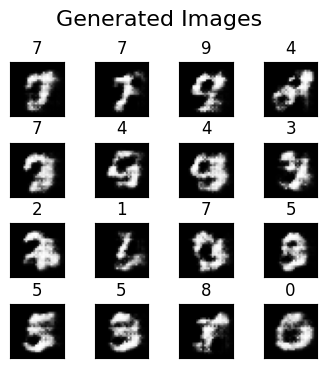

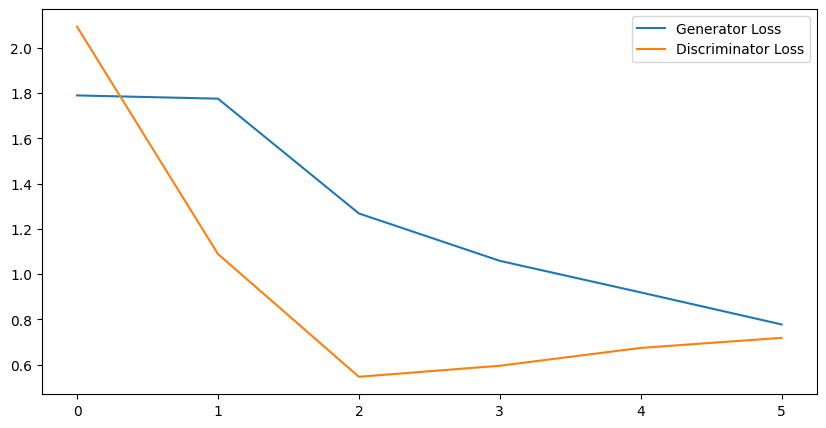

Epoch 7/50


In [ ]:
gan = GAN_trainer(mn_x_train, mn_x_train_labels, beta=0.6, generator_aim="SPECIFIC")

gan.train(epochs=50)

In [168]:
gan.disc_losses

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>,
 <tf.Tensor: shape=(), dtype=float32, numpy=inf>,
 <tf.Tensor: shape=(), dtype=float32, numpy=inf>]

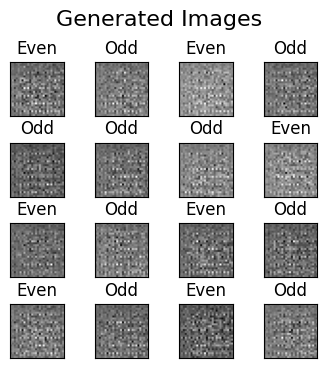

In [82]:
generator = gan.gan.generator

gan = GAN_trainer(mn_x_train, mn_x_train_labels, beta=0.6)

gan.plot_generated_images(epoch = -1, generator_model = generator)

In [ ]:
generator.save('mnist_generatort.h5')

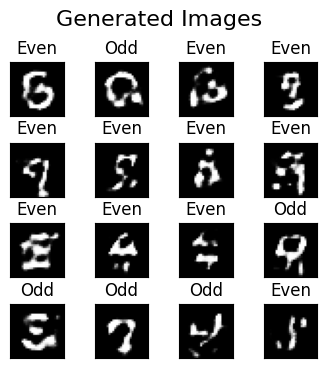

In [91]:
loaded_generator = tf.keras.models.load_model('mnist_generator.h5')

gan = GAN_trainer(mn_x_train, mn_x_train_labels, beta=0.6)

gan.plot_generated_images(epoch = -1, generator_model = loaded_generator, file_name='mnist_generated_images_b0.6_odd_even.png')